In [1]:
import pandas as pd
import numpy as np

# === Load data ===
df = pd.read_csv("NYPD_Complaint_Data_Historic_20250529.csv", skipinitialspace=True, low_memory=False)

# === Keep only Manhattan ===
df = df[df["PATROL_BORO"].str.upper().str.contains("MAN", na=False)]

# === Select relevant columns ===
df = df[["CMPLNT_FR_DT", "OFNS_DESC", "LAW_CAT_CD", "Latitude", "Longitude"]]
df = df.dropna(subset=["Latitude", "Longitude"])

# === Assign severity weight ===
def assign_severity_weight(law_cat):
    if pd.isna(law_cat): return 0
    law_cat = str(law_cat).upper()
    return {"FELONY": 3, "MISDEMEANOR": 2, "VIOLATION": 1}.get(law_cat, 0)

df["severity_weight"] = df["LAW_CAT_CD"].apply(assign_severity_weight)

# === Rename columns ===
df = df.rename(columns={
    "CMPLNT_FR_DT": "Date",
    "OFNS_DESC": "Crime_Type",
    "LAW_CAT_CD": "Severity"
})

# === Clean and convert dates ===
df["Date"] = pd.to_datetime(df["Date"], errors='coerce')
df = df.dropna(subset=["Date", "Crime_Type", "Severity"])
df = df[df["Date"] >= '2000-01-01']

# === Manhattan coordinate bounds (coarse cleanup) ===
df = df[(df["Latitude"] >= 40.70) & (df["Latitude"] <= 40.88) &
        (df["Longitude"] >= -74.02) & (df["Longitude"] <= -73.93)]

# === Remove duplicates ===
df = df.drop_duplicates(subset=["Date", "Crime_Type", "Severity", "Latitude", "Longitude"])

# === Add year column ===
df["Year"] = df["Date"].dt.year

# === Add recency weighting (linear from 0.04 to 1.0) ===
df["recency_weight"] = (df["Year"] - 1999) / 25  # 2000 = 0.04, 2025 = 1.0

# === Final weighted severity = severity × recency ===
df["weighted_severity"] = df["severity_weight"] * df["recency_weight"]

print("✅ Part 1 complete: Data cleaned and recency-weighted")
print(df[["Year", "Severity", "severity_weight", "recency_weight", "weighted_severity"]].head())


✅ Part 1 complete: Data cleaned and recency-weighted
   Year     Severity  severity_weight  recency_weight  weighted_severity
4  2024       FELONY                3             1.0                3.0
5  2024       FELONY                3             1.0                3.0
6  2024  MISDEMEANOR                2             1.0                2.0
7  2024  MISDEMEANOR                2             1.0                2.0
8  2024  MISDEMEANOR                2             1.0                2.0


In [2]:
import geopandas as gpd
from shapely.geometry import Point

# === Convert crimes to GeoDataFrame ===
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["Longitude"], df["Latitude"]),
    crs="EPSG:4326"  # standard lat/lon projection
)

# === Load census tract geometries ===
tracts = gpd.read_file("../census tract geofiles/manhattan_census_tracts.geojson").to_crs(epsg=4326)

# === Spatial join: assign GEOID to each crime ===
joined = gpd.sjoin(
    gdf,
    tracts[["GEOID", "geometry"]],
    how="inner",
    predicate="within"
)

print("✅ Part 2 complete: Crimes are now tagged with GEOIDs.")
print(joined[["Date", "Year", "Severity", "weighted_severity", "GEOID"]].head())


✅ Part 2 complete: Crimes are now tagged with GEOIDs.
        Date  Year     Severity  weighted_severity        GEOID
4 2024-12-01  2024       FELONY                3.0  36061023501
5 2024-12-31  2024       FELONY                3.0  36061021000
6 2024-12-31  2024  MISDEMEANOR                2.0  36061020600
7 2024-12-31  2024  MISDEMEANOR                2.0  36061027900
8 2024-12-31  2024  MISDEMEANOR                2.0  36061024302


In [3]:
import geopandas as gpd
from shapely.geometry import Point

# === Convert crimes to GeoDataFrame ===
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["Longitude"], df["Latitude"]),
    crs="EPSG:4326"  # standard lat/lon projection
)

# === Load census tract geometries ===
tracts = gpd.read_file("../census tract geofiles/manhattan_census_tracts.geojson").to_crs(epsg=4326)

# === Spatial join: assign GEOID to each crime ===
joined = gpd.sjoin(
    gdf,
    tracts[["GEOID", "geometry"]],
    how="inner",
    predicate="within"
)

print("✅ Part 2 complete: Crimes are now tagged with GEOIDs.")
print(joined[["Date", "Year", "Severity", "weighted_severity", "GEOID"]].head())


✅ Part 2 complete: Crimes are now tagged with GEOIDs.
        Date  Year     Severity  weighted_severity        GEOID
4 2024-12-01  2024       FELONY                3.0  36061023501
5 2024-12-31  2024       FELONY                3.0  36061021000
6 2024-12-31  2024  MISDEMEANOR                2.0  36061020600
7 2024-12-31  2024  MISDEMEANOR                2.0  36061027900
8 2024-12-31  2024  MISDEMEANOR                2.0  36061024302


In [4]:
# === Group by GEOID and Year, sum weighted severity ===
grouped = joined.groupby(["GEOID", "Year"])["weighted_severity"].sum().reset_index()

# === Create full table with all years and tracts ===
years = range(2000, 2025)  # Exclude 2025 — last year with real data is 2024
all_tracts = tracts["GEOID"].unique()
full_index = pd.MultiIndex.from_product([all_tracts, years], names=["GEOID", "Year"])

# === Fill in missing years with 0 ===
grouped_full = grouped.set_index(["GEOID", "Year"]).reindex(full_index, fill_value=0).reset_index()

# === Pivot into wide format (columns: year_2000, ..., year_2024) ===
historical_wide = grouped_full.pivot(index="GEOID", columns="Year", values="weighted_severity").reset_index()

# === Rename year columns ===
historical_wide.columns = ["GEOID"] + [f"year_{col}" for col in historical_wide.columns[1:]]

# === DEBUGGING: Check for missing or uniform values in each year ===
year_cols = [col for col in historical_wide.columns if col.startswith("year_")]

for col in year_cols:
    print(f"--- {col} ---")
    print(historical_wide[col].describe())
    print("Most common values:")
    print(historical_wide[col].value_counts().head(3))
    print("\n")

print("✅ Part 3 complete: Historical scores 2000–2024 in wide format.")
print(historical_wide.head())


--- year_2000 ---
count    310.000000
mean       0.056387
std        0.098742
min        0.000000
25%        0.000000
50%        0.000000
75%        0.080000
max        0.600000
Name: year_2000, dtype: float64
Most common values:
year_2000
0.00    193
0.12     42
0.08     34
Name: count, dtype: int64


--- year_2001 ---
count    310.000000
mean       0.150194
std        0.256775
min        0.000000
25%        0.000000
50%        0.000000
75%        0.240000
max        2.080000
Name: year_2001, dtype: float64
Most common values:
year_2001
0.00    183
0.24     47
0.16     21
Name: count, dtype: int64


--- year_2002 ---
count    310.000000
mean       0.229935
std        0.391670
min        0.000000
25%        0.000000
50%        0.000000
75%        0.360000
max        2.520000
Name: year_2002, dtype: float64
Most common values:
year_2002
0.00    180
0.36     40
0.24     34
Name: count, dtype: int64


--- year_2003 ---
count    310.000000
mean       0.420645
std        0.669132
min       

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import pandas as pd

# === Prepare data for modeling ===
future_years = [2025, 2026, 2027]
future_preds = []

for _, row in historical_wide.iterrows():
    geoid = row["GEOID"]
    
    # Extract original years and values
    original_years = np.arange(2000, 2025).reshape(-1, 1)
    y_values = row[[f"year_{y}" for y in range(2000, 2025)]].values.reshape(-1, 1)

    # Optional smoothing: extend with a copy of 2024 as synthetic anchor for 2025
    X = np.vstack([original_years, [[2025]]])
    y = np.vstack([y_values, [[y_values[-1][0]]]])  # Extend with last value
    
    # If data is too flat, skip modeling
    if len(np.unique(y)) < 3:
        val = float(y.mean())
        future_preds.append({
            "GEOID": geoid,
            "pred_2025": val,
            "pred_2026": val,
            "pred_2027": val
        })
        continue

    # Polynomial regression (degree 2)
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X)
    model = LinearRegression()
    model.fit(X_poly, y)

    # Predict future years
    future_X_poly = poly.transform(np.array(future_years).reshape(-1, 1))
    future_scores = model.predict(future_X_poly).flatten()

    future_preds.append({
        "GEOID": geoid,
        "pred_2025": round(float(future_scores[0]), 2),
        "pred_2026": round(float(future_scores[1]), 2),
        "pred_2027": round(float(future_scores[2]), 2)
    })

predicted_df = pd.DataFrame(future_preds)
print("✅ Part 4 updated: Polynomial regression with anchor smoothing applied.")


✅ Part 4 updated: Polynomial regression with anchor smoothing applied.


In [6]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# === Merge historical and predicted data ===
full_df = historical_wide.merge(predicted_df, on="GEOID", how="left")

# === Identify columns
hist_cols = [col for col in full_df.columns if col.startswith("year_")]
pred_cols = [col for col in full_df.columns if col.startswith("pred_")]
all_score_cols = hist_cols + pred_cols

# === Drop columns with no variation
all_score_cols = [col for col in all_score_cols if full_df[col].nunique() > 1]

# === Normalize entire 2000–2027 range together
scaler = MinMaxScaler(feature_range=(1, 10))
norm_df = full_df.copy()
norm_scores = scaler.fit_transform(full_df[all_score_cols])
norm_df[all_score_cols] = 11 - norm_scores  # flip: more crime → lower safety score

# === Optional: round only for display
norm_df[hist_cols] = norm_df[hist_cols].round(2)
norm_df[pred_cols] = norm_df[pred_cols].round(2)  # keep slightly higher precision for predictions

# === Save to CSV
norm_df.to_csv("full_crime_score_by_tract_2000_2027.csv", index=False)
print("✅ Part 5 complete: File saved as 'full_crime_score_by_tract_2000_2027.csv'")
print(norm_df[["GEOID"] + pred_cols].head())

# === Post-normalization audit: check how many predictions are identical
ident_25_26 = (norm_df["pred_2025"] == norm_df["pred_2026"]).mean()
ident_25_27 = (norm_df["pred_2025"] == norm_df["pred_2027"]).mean()
ident_26_27 = (norm_df["pred_2026"] == norm_df["pred_2027"]).mean()

print(f"🔍 % rows where pred_2025 == pred_2026: {ident_25_26:.2%}")
print(f"🔍 % rows where pred_2025 == pred_2027: {ident_25_27:.2%}")
print(f"🔍 % rows where pred_2026 == pred_2027: {ident_26_27:.2%}")

# === Check jump between year_2024 and pred_2025
if "year_2024" in norm_df.columns:
    delta = norm_df["pred_2025"] - norm_df["year_2024"]
    print(f"\n📉 Average jump from 2024 to 2025: {delta.mean():.2f}")
    print(f"📊 Max jump: {delta.max():.2f} | Min jump: {delta.min():.2f}")


✅ Part 5 complete: File saved as 'full_crime_score_by_tract_2000_2027.csv'
         GEOID  pred_2025  pred_2026  pred_2027
0  36061000100      10.00      10.00      10.00
1  36061000201       9.10       9.11       9.12
2  36061000202       8.47       8.48       8.49
3  36061000500      10.00      10.00      10.00
4  36061000600       7.54       7.57       7.60
🔍 % rows where pred_2025 == pred_2026: 16.77%
🔍 % rows where pred_2025 == pred_2027: 9.68%
🔍 % rows where pred_2026 == pred_2027: 16.77%

📉 Average jump from 2024 to 2025: -0.08
📊 Max jump: 0.53 | Min jump: -0.69


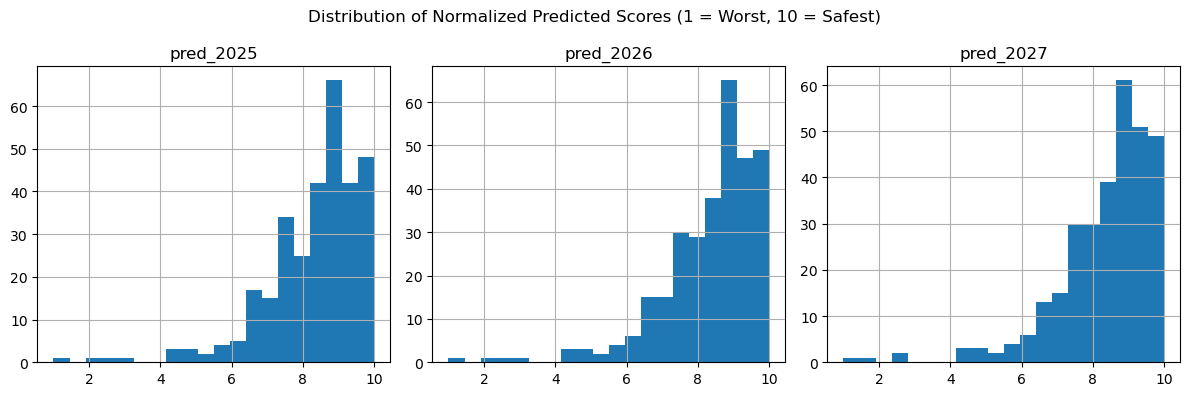

In [7]:
import matplotlib.pyplot as plt

norm_df[["pred_2025", "pred_2026", "pred_2027"]].hist(bins=20, figsize=(12, 4), layout=(1, 3))
plt.suptitle("Distribution of Normalized Predicted Scores (1 = Worst, 10 = Safest)")
plt.tight_layout()
plt.show()
